In [ ]:
!pip install fastcluster

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from yellowbrick.cluster import KElbowVisualizer
import fastcluster
from google.colab import files
%config InlineBackend.figure_format = 'retina'
import sys
sys.setrecursionlimit(10000)

from sklearn.datasets import make_blobs


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

##***SECTION 1 - Please be aware that the following section is exploring the PCA + KMeans combination for clustering. This isn't our final solution because of its "blackbox" approach.***




In [ ]:
#Import data
df = pd.read_excel("DentMax Case Dataset(1).xlsx")

#Drop empty column
df.drop(columns="Unnamed: 0",inplace=True)
df.set_index('Observations / Segmentation Variables',inplace=True)

#Standardization of the original dataframe
x = df.values
scaler = StandardScaler()
scaled = scaler.fit_transform(x)

#Creation of the new dataframe using standardized values
data = pd.DataFrame(scaled,columns=df.columns.values).rename_axis('Observations / Segmentation Variables')

0.9257816815116523


,0,1,2,3
0,-0.862626,-0.429569,-1.856115,0.650126
1,-1.672741,-0.211285,-1.338376,1.066017
2,-0.520881,-0.374682,-1.993491,0.605784
3,-1.383889,-0.437405,-1.043649,1.108985
4,-1.532189,-0.077139,-0.842020,-0.792354
...,...,...,...,...
2295,-0.878936,-0.007590,-2.066111,0.826161
2296,-1.238460,-0.411167,-0.526545,-0.776031
2297,3.822014,-2.332316,1.195525,0.444987
2298,-1.100213,-0.901777,-1.001533,0.860172


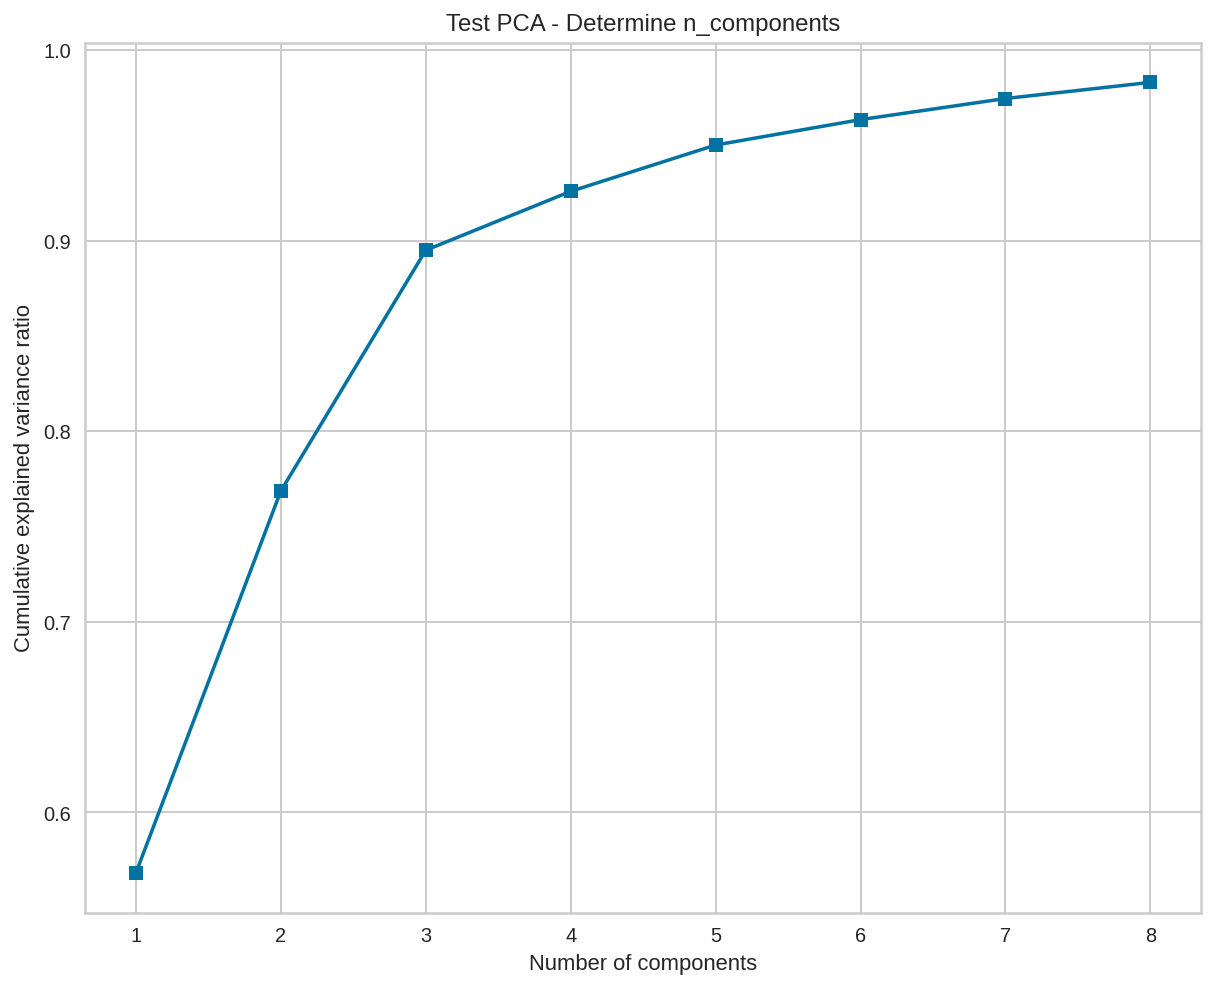

In [ ]:
#Use PCA for dimensionality reduction
#1 Choose n_components (This is the cumulative variance plot)
pca_test = PCA(n_components=8)
pca_test.fit_transform(data)
plt.figure(figsize=(10,8))
plt.plot(range(1,9),pca_test.explained_variance_ratio_.cumsum(),marker='s')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Test PCA - Determine n_components')

#2 Perform the PCA with the right number of components (rule of thumb, the components should explain arround 90% of the variance)
pca = PCA(n_components=4)
principal_components = pca.fit_transform(data)
data_pca = pd.DataFrame(principal_components)
print(pca.explained_variance_ratio_.sum())
data_pca

In [ ]:
#Creation of the K-MEANS clustering algorithm and hyperparameter optimization
parameter = {'n_clusters':np.arange(1,20)}
kmeans = KMeans()
kmeans_cv = GridSearchCV(kmeans,param_grid=parameter,cv=5)

#Perform the KMeans clustering and determining the best n_cluster
kmeans_cv.fit(data_pca)
print(kmeans_cv.best_params_)

#Determine KMeans with n_cluster accoridng to last results
km = KMeans(n_clusters=4,random_state=10)
km.fit(data_pca)
clusters = km.predict(data_pca)
clusters = clusters.reshape(-1,1)

#Identification of centroids
centers = np.array(km.cluster_centers_)


{'n_clusters': 19}


In [ ]:
#Creation of the new dataset with clusters
df_pca = data_pca
df_pca['Cluster'] = clusters
df_pca.rename(columns={0:'Component_1',1:'Component_2',2:'Component_3',3:'Component_4'},inplace=True)

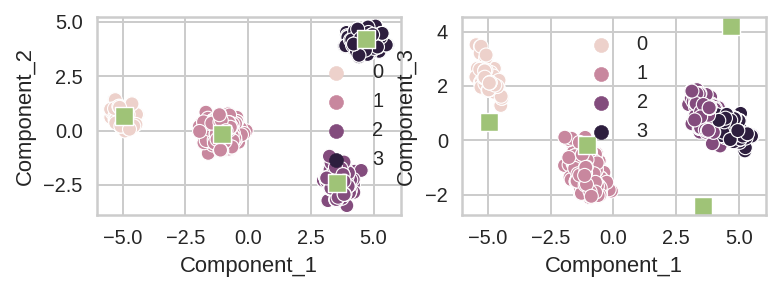

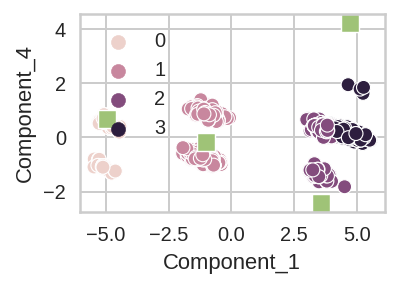

In [ ]:
#Plotting the Kmeans clustering with PCA
'''
cluster_0 = df_pca[df_pca['Cluster'] == 0]
cluster_1 = df_pca[df_pca['Cluster'] == 1]
cluster_2 = df_pca[df_pca['Cluster'] == 2]
cluster_3 = df_pca[df_pca['Cluster'] == 3]
'''

plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x='Component_1',y='Component_2',hue='Cluster')
sns.scatterplot(data=centers, x=centers[:,0],y=centers[:,1],marker='s',s=80)
plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x='Component_1',y='Component_3',hue='Cluster')
sns.scatterplot(data=centers, x=centers[:,0],y=centers[:,1],marker='s',s=80)
plt.show()
plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x='Component_1',y='Component_4',hue='Cluster')

#Ploting centroids
sns.scatterplot(data=centers, x=centers[:,0],y=centers[:,1],marker='s',s=80)


##***SECTION 2 - This section present our final approach regarding the clustering of the dataset. Instead of using PCA, we select features based on their relative importance compared to others. The latter are divided between perceptual and behavioral features.***




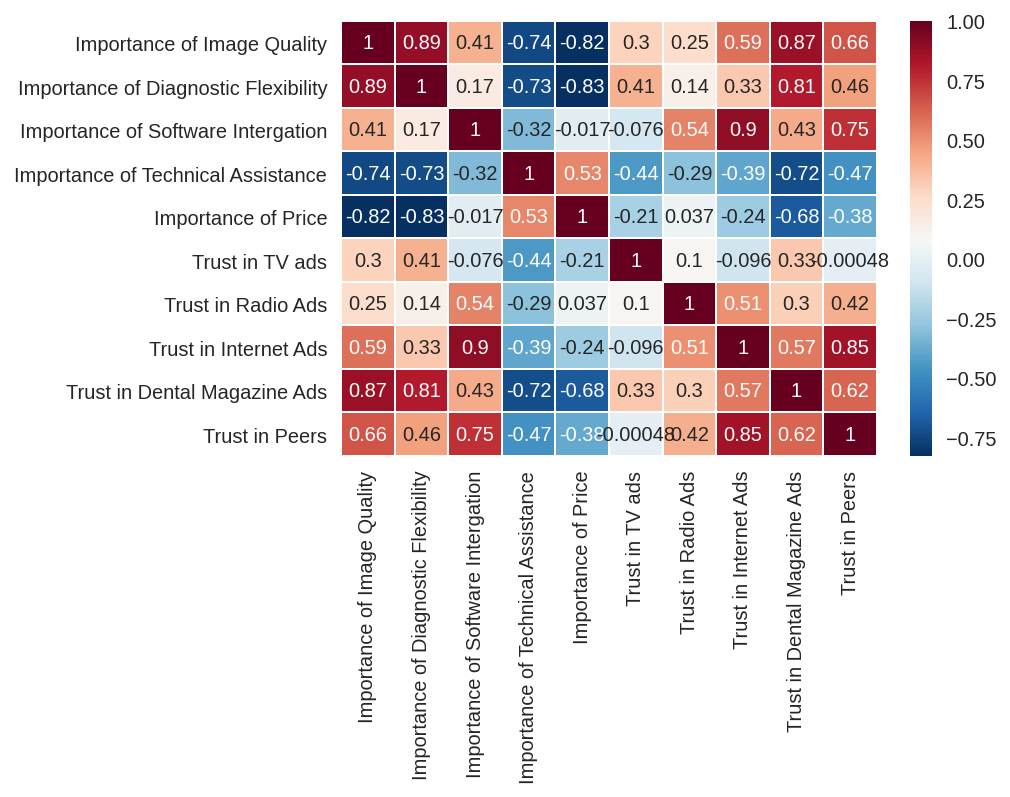

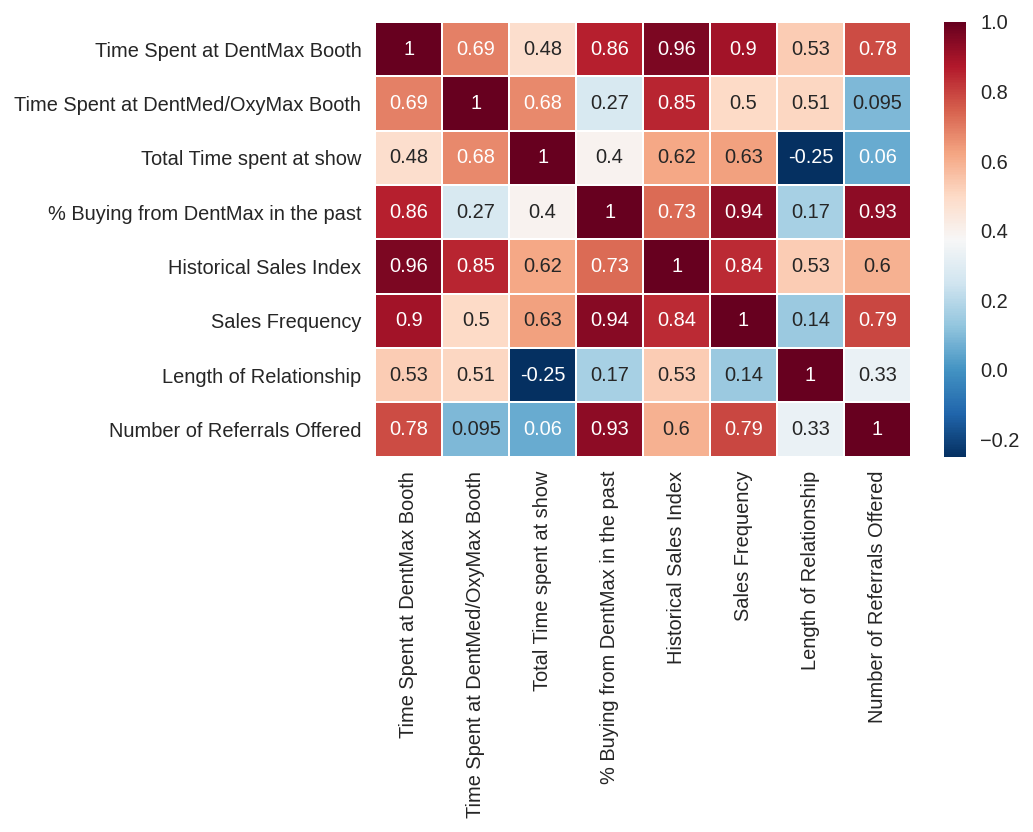

In [ ]:
##Based on the teacher's feedback, the selection of the attributes is the most transparent method##

#Split the dataset into perceptual and behavioral dimensions
df_perceptual = data[['Importance of Image Quality','Importance of Diagnostic Flexibility','Importance of Software Intergation','Importance of Technical Assistance','Importance of Price','Trust in TV ads','Trust in Radio Ads','Trust in Internet Ads','Trust in Dental Magazine Ads','Trust in Peers']]
df_behavioral = data[['Time Spent at DentMax Booth','Time Spent at DentMed/OxyMax Booth','Total Time spent at show','% Buying from DentMax in the past','Historical Sales Index','Sales Frequency','Length of Relationship','Number of Referrals Offered']]


#First look at the descriptive statistic (mean) of the dataset (non standardized) to detect the most important attributes
x = pd.DataFrame(df[df_perceptual.columns].mean())
x.sort_values(by=0)

#The top Perceptual attributes
  #Importance of Image Quality	5.257826
  #Trust in Dental Magazine Ads	5.352609
  #Trust in Peers	5.940870
  #Importance of Technical Assistance	6.134348
  #Importance of Price	6.408696

y = pd.DataFrame(data[df_behavioral.columns].mean())
y.sort_values(by=0)

#The top Behavioral attributes (with standardized values)
  #Time Spent at DentMax Booth	1.392123e-16
  #Sales Frequency	1.395502e-16
  #Historical Sales Index	1.883517e-16
  #Time Spent at DentMed/OxyMax Booth	2.581027e-16
  #Number of Referrals Offered	3.330910e-16

#Then compute the correlation coefficeint to filter variable that we assume as similar : two dimensions perceptual and behavioral
df_perceptual = data[['Importance of Image Quality','Importance of Diagnostic Flexibility','Importance of Software Intergation','Importance of Technical Assistance','Importance of Price','Trust in TV ads','Trust in Radio Ads','Trust in Internet Ads','Trust in Dental Magazine Ads','Trust in Peers']]
pearson = df_perceptual.corr(method='pearson')

sns.heatmap(pearson, 
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

plt.show()


df_behavioral = data[['Time Spent at DentMax Booth','Time Spent at DentMed/OxyMax Booth','Total Time spent at show','% Buying from DentMax in the past','Historical Sales Index','Sales Frequency','Length of Relationship','Number of Referrals Offered']]
pearson1 = df_behavioral.corr(method='pearson')

sns.heatmap(pearson1, 
            xticklabels=pearson1.columns,
            yticklabels=pearson1.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()



#Selection of the attributes (Based on the pearsonr tables) = If some attributes are strongly correlated we keep only one
df_selected_p = df_perceptual[['Importance of Price','Importance of Technical Assistance','Trust in Peers','Importance of Image Quality']]
df_selected_b = df_behavioral[['Number of Referrals Offered','Historical Sales Index']]

#Concat the final dataframe with the selected features
list_final_df = [df_selected_p,df_selected_b]
final_df = pd.concat(list_final_df, axis=1)

In [ ]:
#Creation of the KMeans clustering method and hyperparameter tunning
parameters = {'n_clusters':np.arange(1,5)}
kmeans_selected = KMeans()
kmeans_selected_cv = GridSearchCV(kmeans_selected,param_grid=parameters,cv=3)

#Perform the KMeans clustering and determining the best n_cluster
kmeans_selected_cv.fit(final_df)
print(kmeans_selected_cv.best_params_)

#Determine KMeans with n_cluster accoridng to last results
km_ = KMeans(n_clusters=4,random_state=10)
km_.fit(final_df)
clusters = km_.predict(final_df)
clusters = clusters.reshape(-1,1)

#Identification of centroids
centers_final = np.array(km_.cluster_centers_)

#Creation of the final dataframe with clusters
df_final_cluster = final_df.copy()
df_final_cluster['Cluster'] = clusters

{'n_clusters': 4}


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


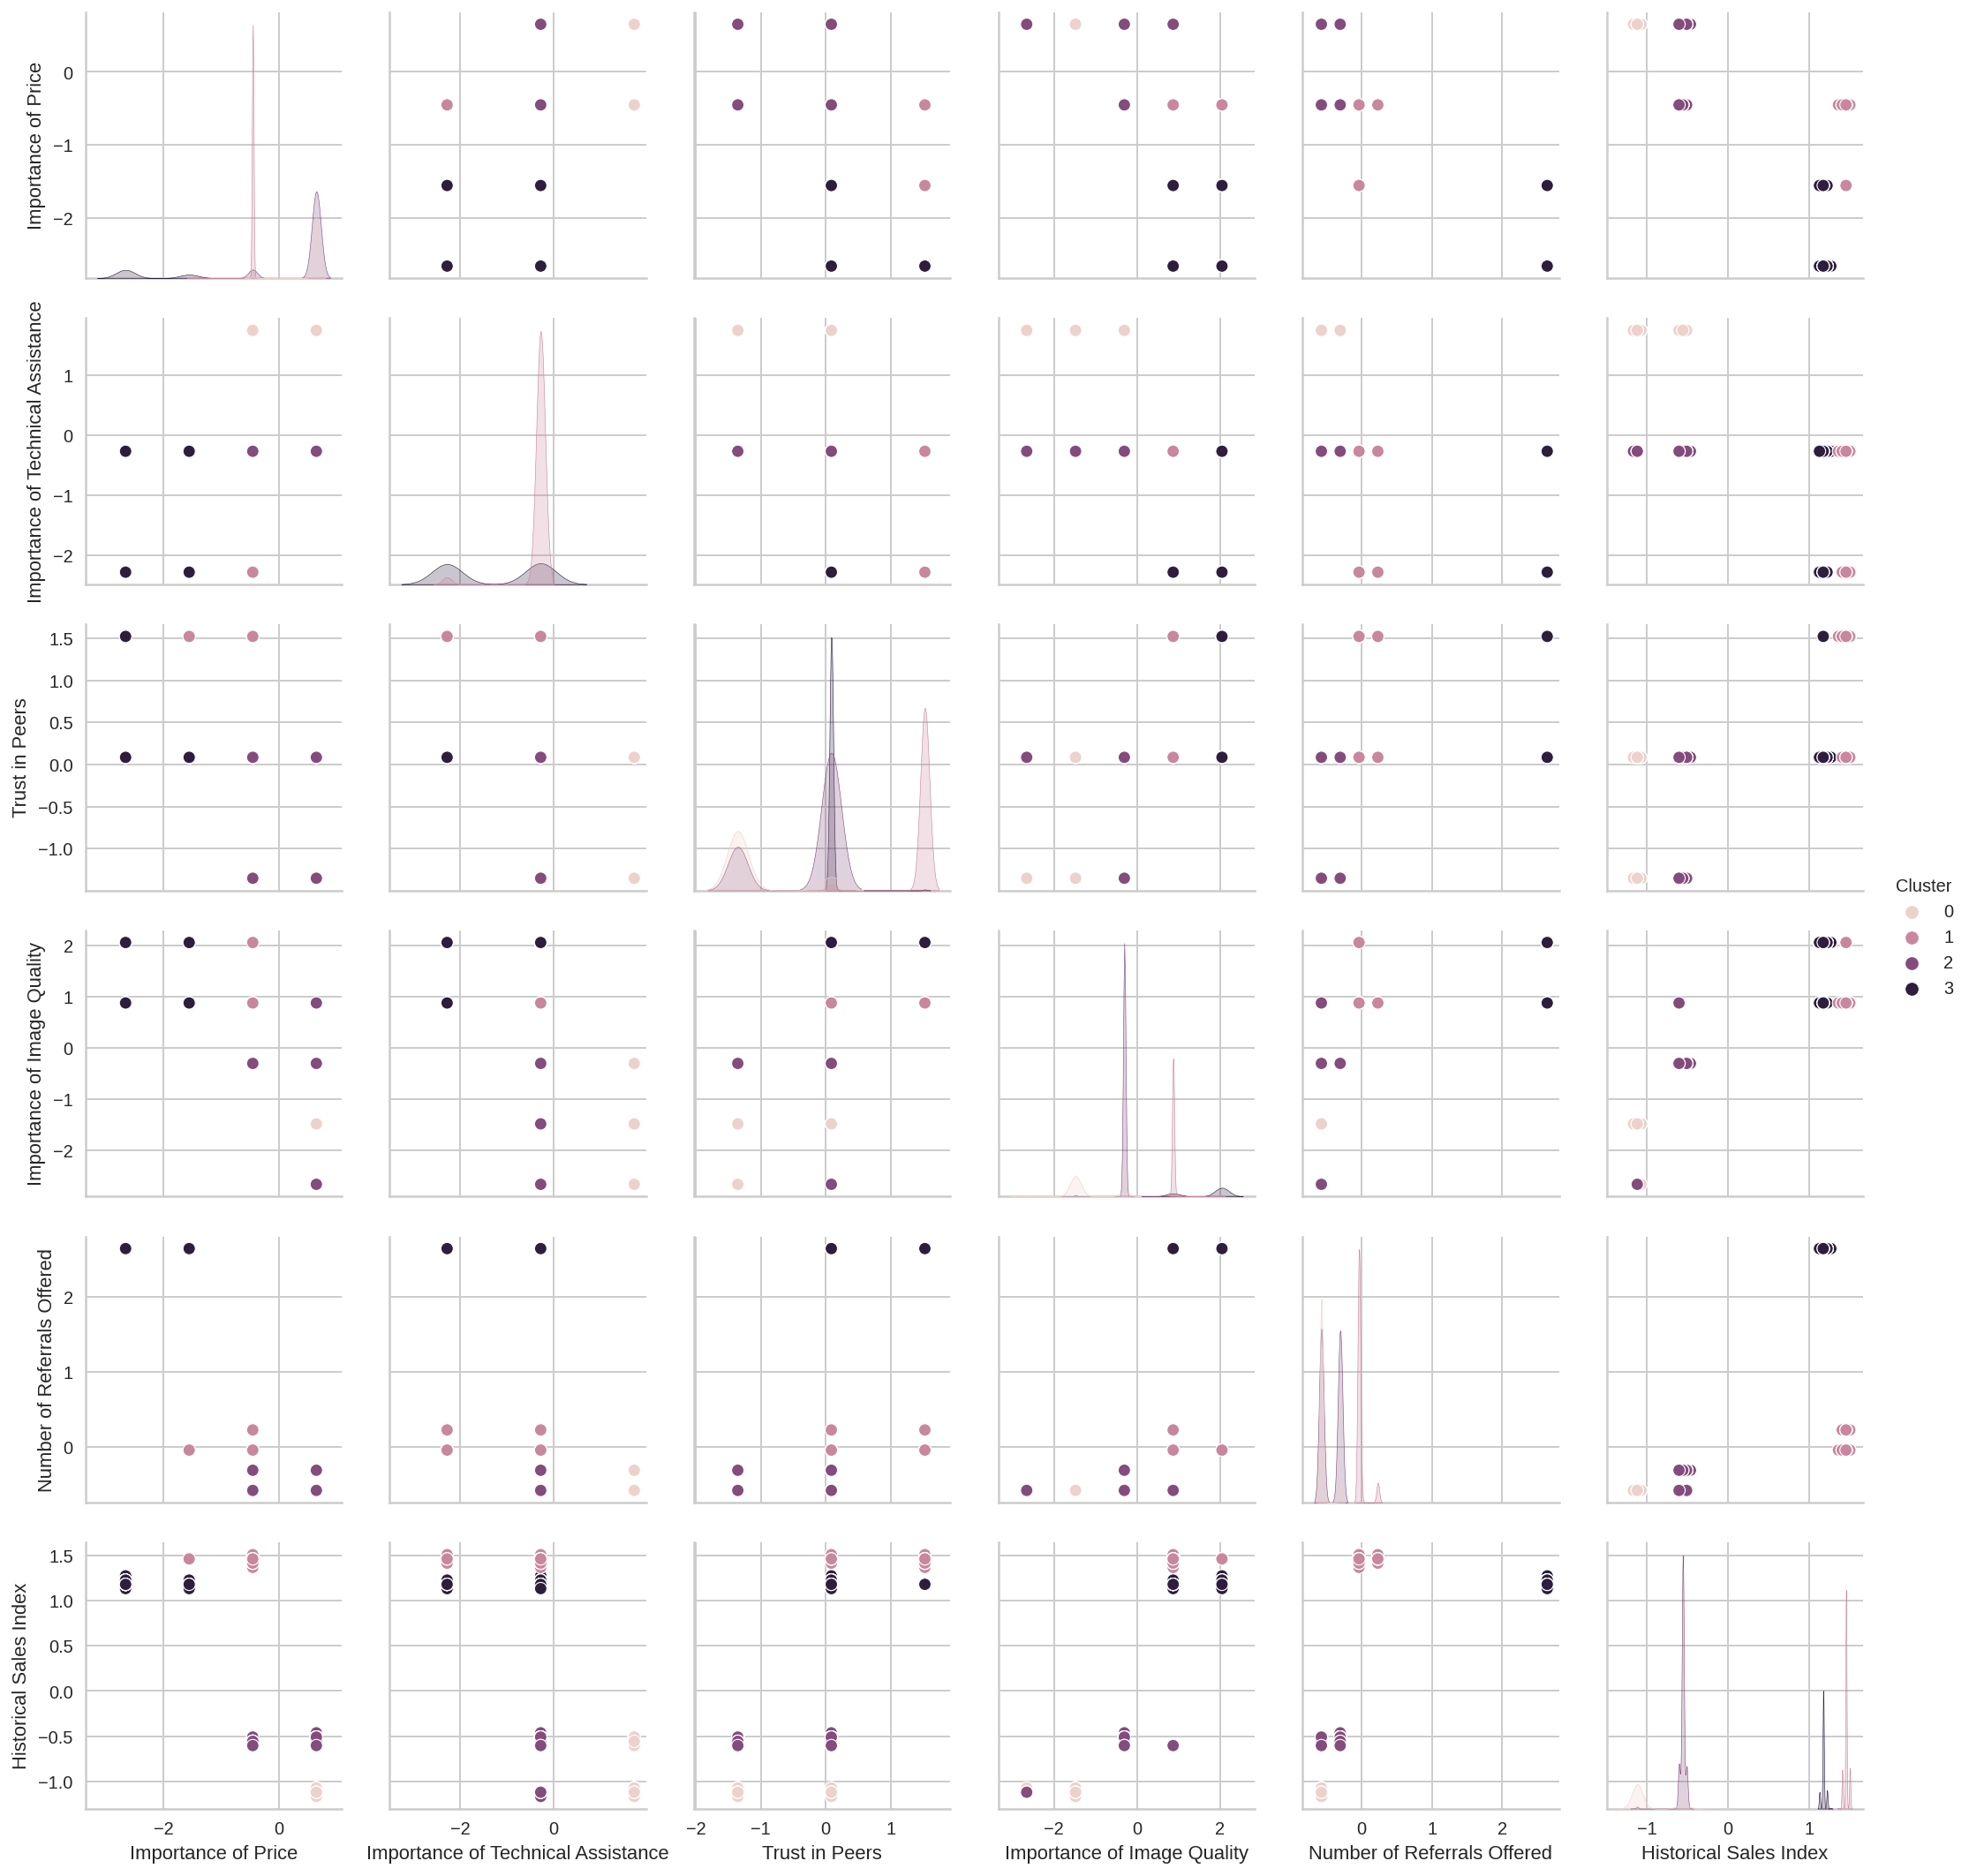

In [ ]:
#Plot KMeans cluster - With pariplot (Scatters)
sns.pairplot(df_final_cluster,hue='Cluster')
plt.show()

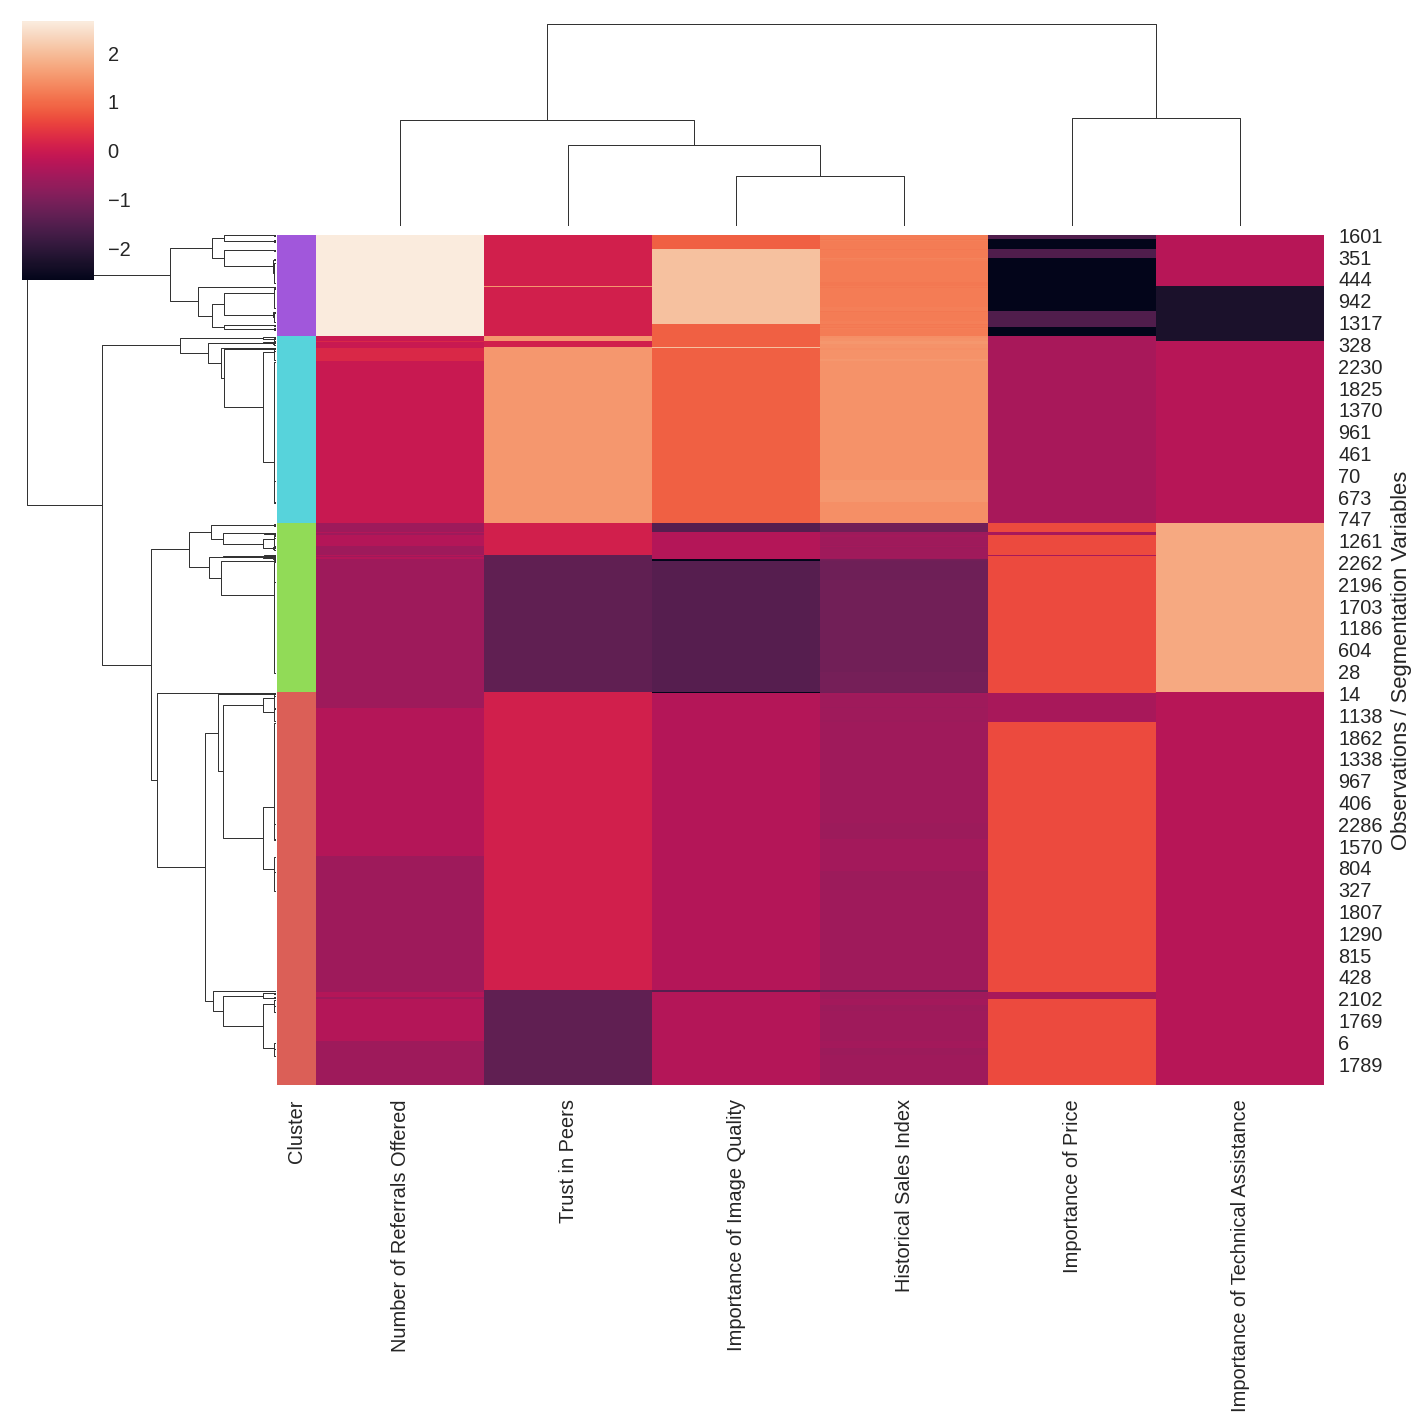

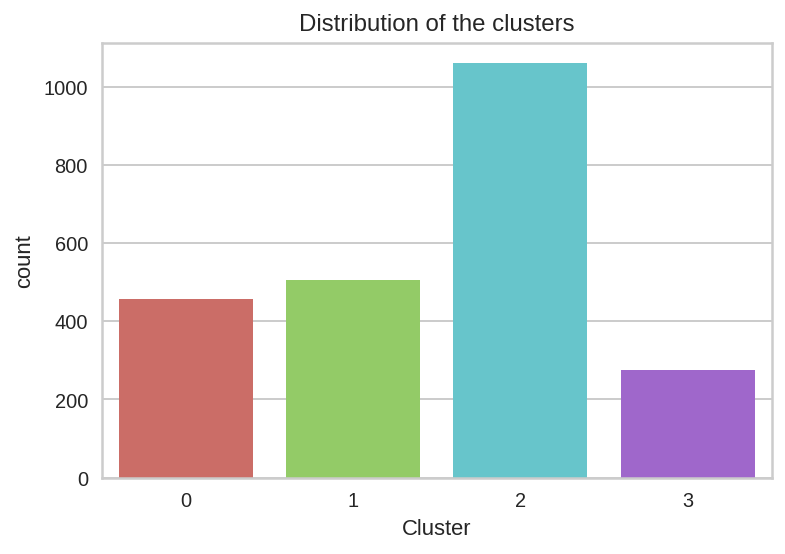

In [ ]:
#Plot Hierarchical clustering - With clustermap
palette = sns.color_palette("hls", 4)
lut = dict(zip(df_final_cluster.Cluster.unique(), palette))
row_colors = df_final_cluster.Cluster.map(lut)

# The colors assoicated to the legend cluster = plt.legend(['r','g','b','p'],[0,1,2,3])

#Actual clustermap + Dendrogram
g = sns.clustermap(final_df,row_colors=row_colors)
plt.show()

#Distribution of the cluster
sns.countplot(data=df_final_cluster,x='Cluster',palette="hls")
plt.title('Distribution of the clusters')
plt.show()

##***SECTION 3 - This section focus the segmentation approach on only the "needs" of the dentists.***




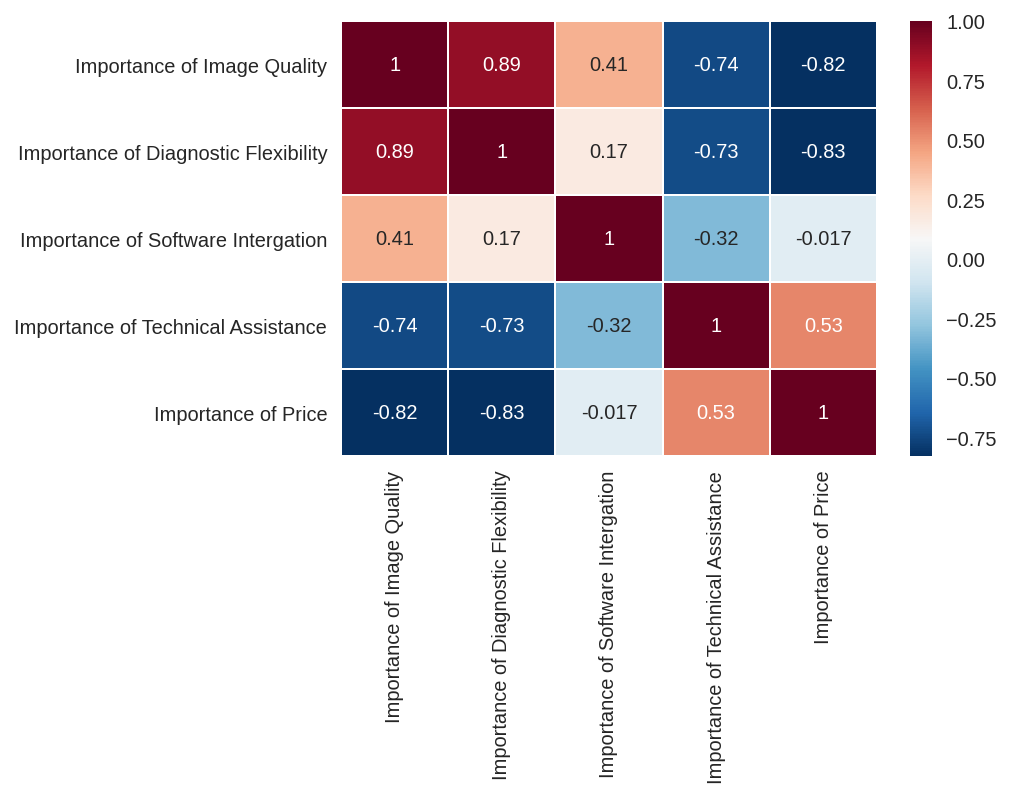

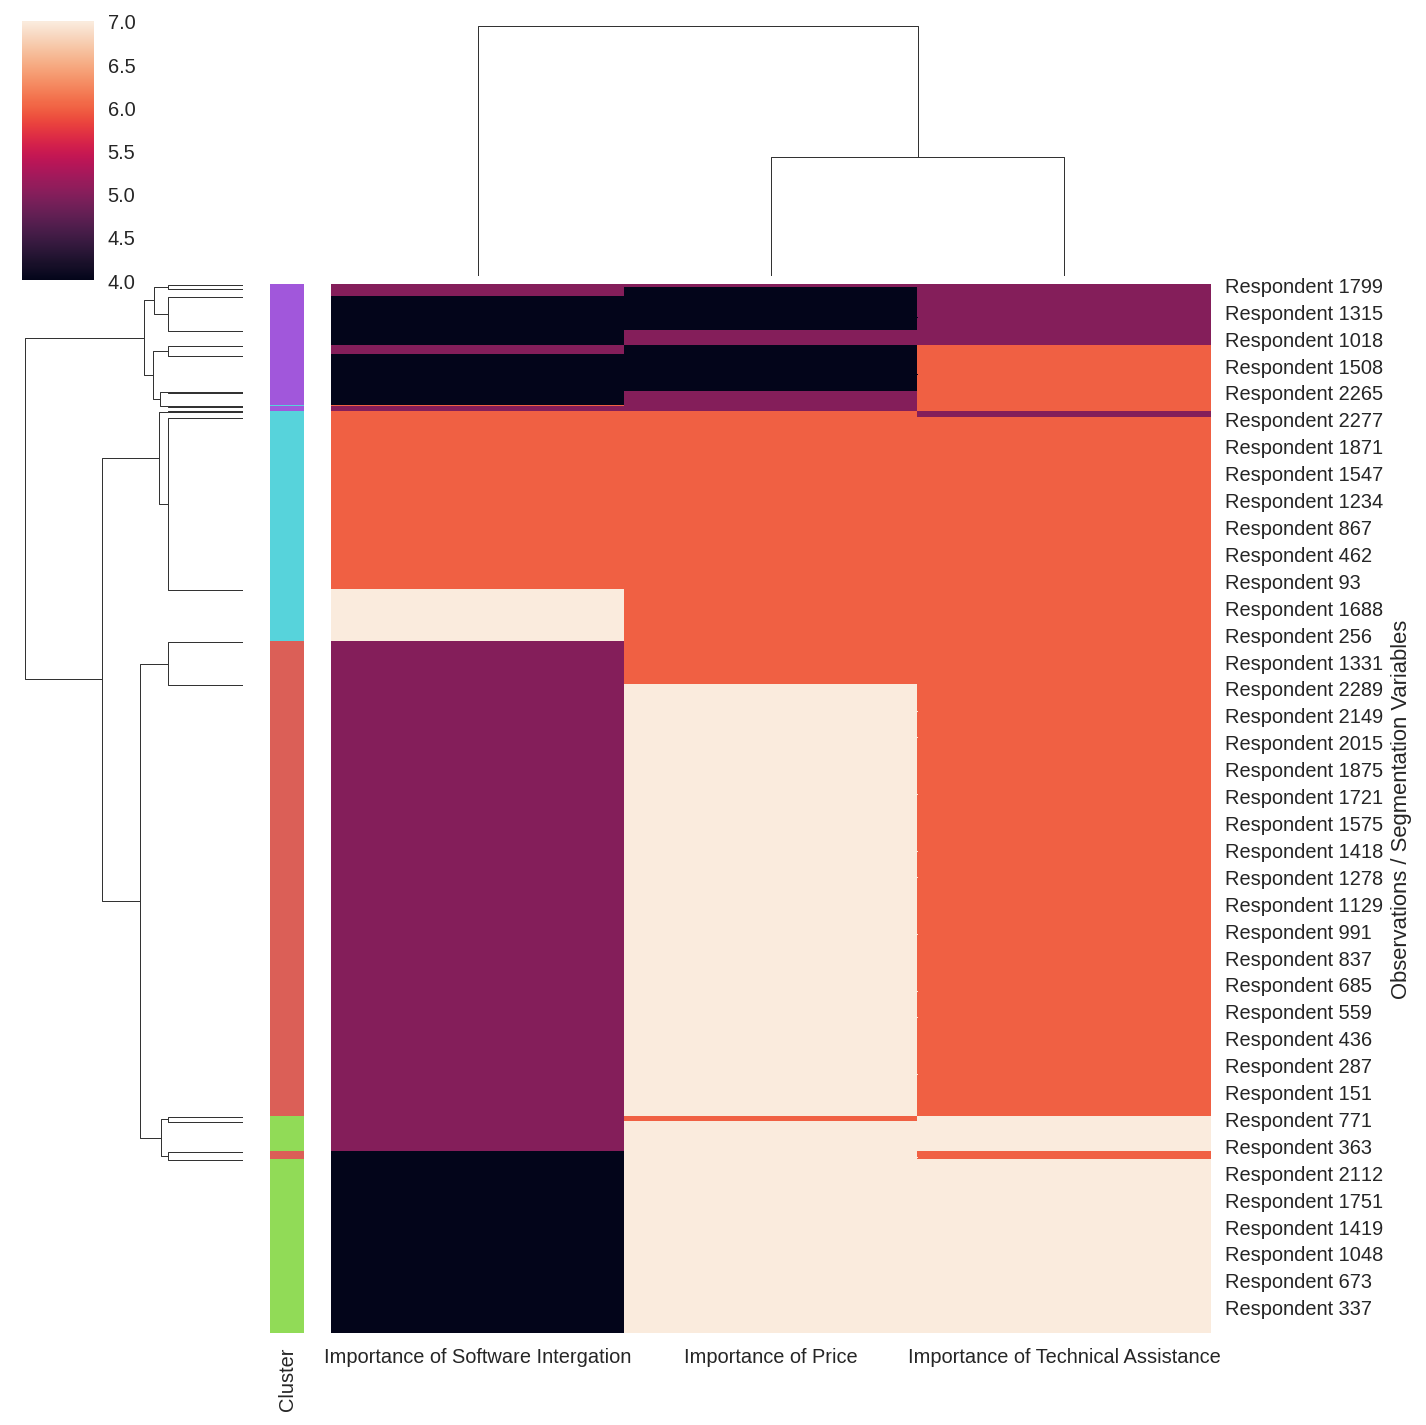

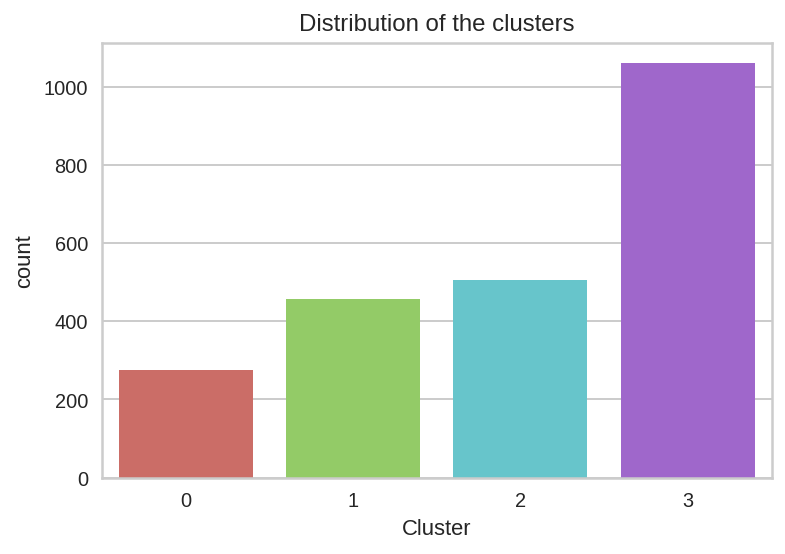

In [ ]:
## AS WE'RE FOCUSING ON DATA WITH THE SAME SCALE, WE DO NOT USE STANDARDIZED DATA##
#Dataset using only needs of dentists
df_perceptual_bis = df[['Importance of Image Quality','Importance of Diagnostic Flexibility','Importance of Software Intergation','Importance of Technical Assistance','Importance of Price']]

#Correlation matrix
pearson_bis = df_perceptual_bis.corr(method='pearson')

sns.heatmap(pearson_bis, 
            xticklabels=pearson_bis.columns,
            yticklabels=pearson_bis.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

plt.show()

#New dataset
df_final_bis = df[['Importance of Price','Importance of Software Intergation','Importance of Technical Assistance']]

#Kmean
km_bis = KMeans(n_clusters=4)
km_bis.fit(df_final_bis)
Cluster_bis = km_bis.predict(df_final_bis)

#Creation of the new dataframe
df_final_bis_clustered = df_final_bis.copy()
df_final_bis_clustered['Cluster'] = Cluster_bis

#Plot Hierarchical clustering - With clustermap
palette_bis = sns.color_palette("hls", 4)
lut = dict(zip(df_final_bis_clustered.Cluster.unique(), palette_bis))
row_colors_bis = df_final_bis_clustered.Cluster.map(lut)

# The colors assoicated to the legend cluster = plt.legend(['r','g','b','p'],[0,1,2,3])

#Actual clustermap + Dendrogram
f = sns.clustermap(df_final_bis,row_colors=row_colors_bis)
plt.show()

#Distribution of the cluster
sns.countplot(data=df_final_bis_clustered,x='Cluster',palette="hls")
plt.title('Distribution of the clusters')
plt.show()

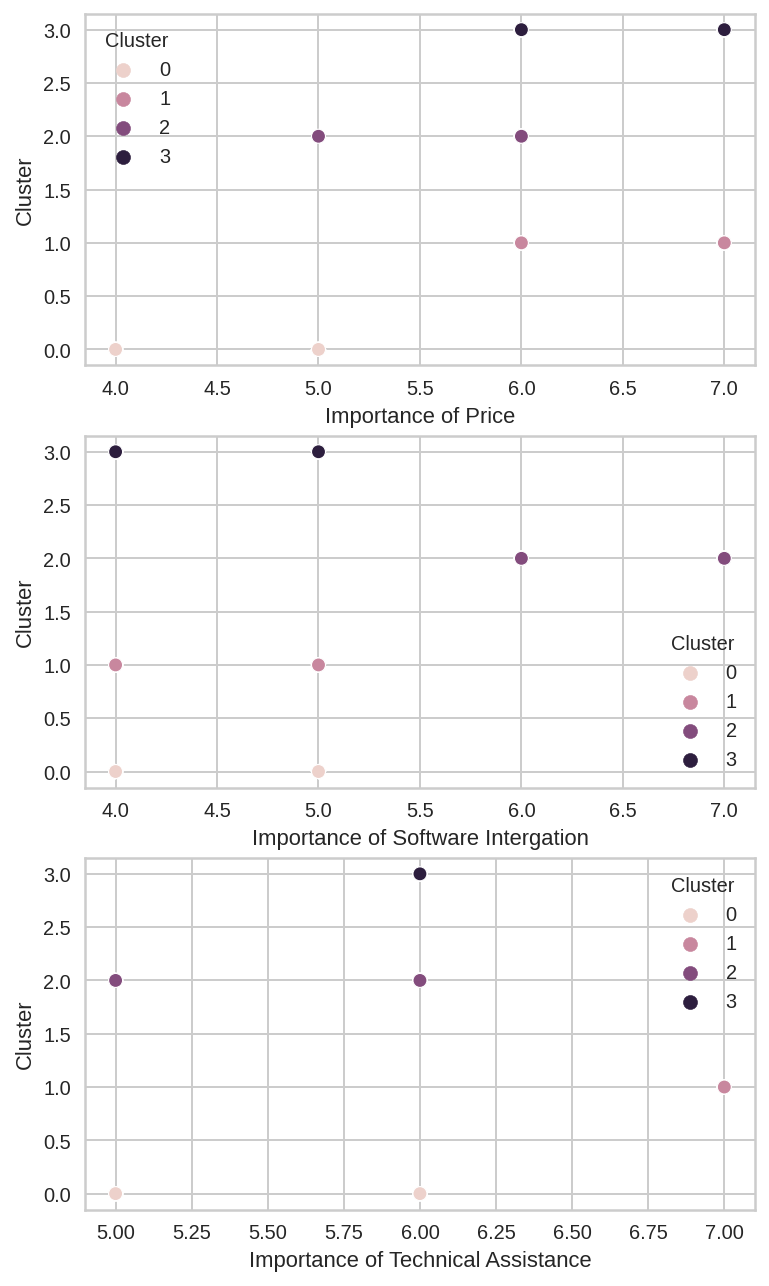

In [ ]:
#Visualize clusters with scatterplots - By Attributes
plt.figure(figsize=(6,11))

plt.subplot(3,1,1)
sns.scatterplot(data=df_final_bis_clustered, x='Importance of Price',y='Cluster',hue='Cluster')

plt.subplot(3,1,2)
sns.scatterplot(data=df_final_bis_clustered, x='Importance of Software Intergation',y='Cluster',hue='Cluster')

plt.subplot(3,1,3)
sns.scatterplot(data=df_final_bis_clustered, x='Importance of Technical Assistance',y='Cluster',hue='Cluster')


##***SECTION 4 - This section focus on the use of PCA and correlation matrix to perform KMean clustering (Using Knime partially).***

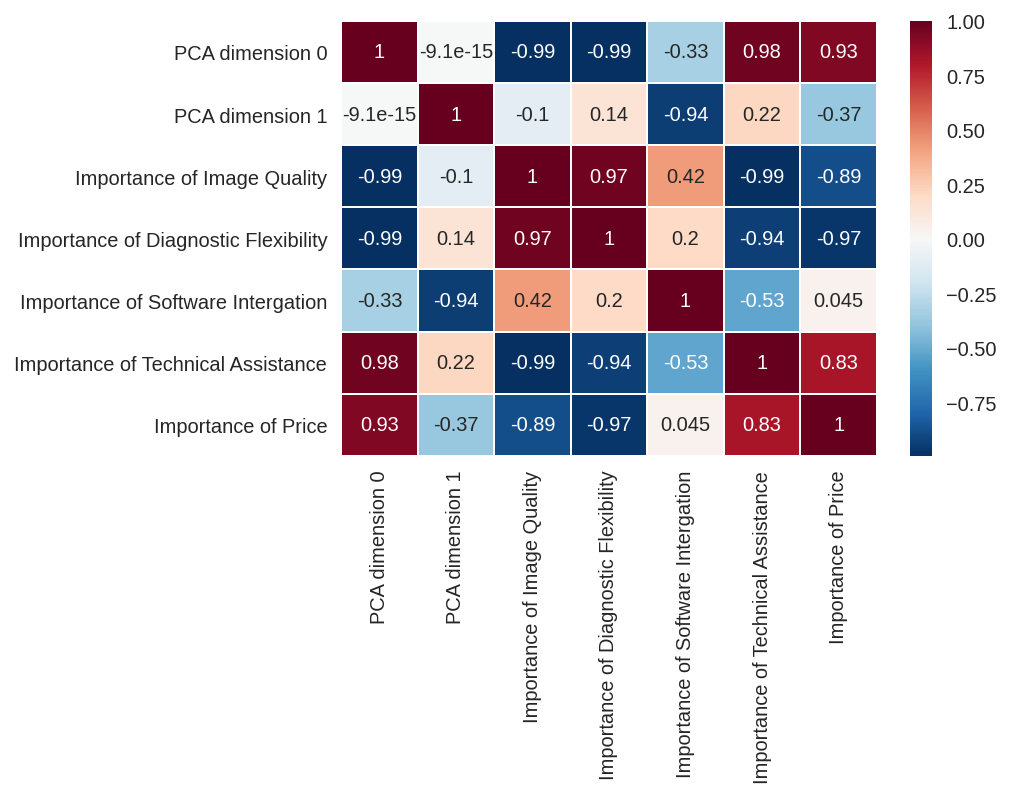

In [ ]:
#Read the dataset
knime = pd.read_excel('KNIME_DATASET.xlsx')
knime.drop(columns=['Cluster'],inplace=True)

#Compute pearson R between the features
pearson_knime = knime.corr(method='pearson') 

#Plot the correlation matrix to identify what are the features representing the most PCA components
sns.heatmap(pearson_knime, 
            xticklabels=pearson_knime.columns,
            yticklabels=pearson_knime.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

plt.show()


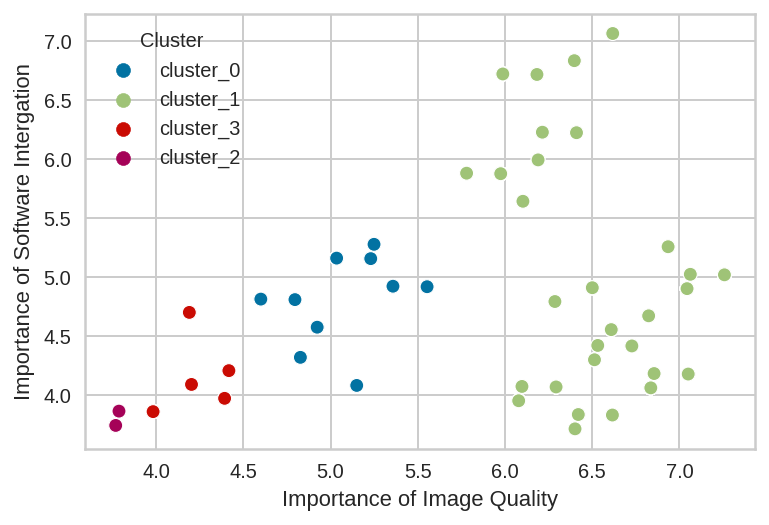

In [ ]:
knime_bis = pd.read_excel('KNIME_DATASET.xlsx')

sns.scatterplot(data=knime_bis, x='Importance of Image Quality',y='Importance of Software Intergation',hue='Cluster')

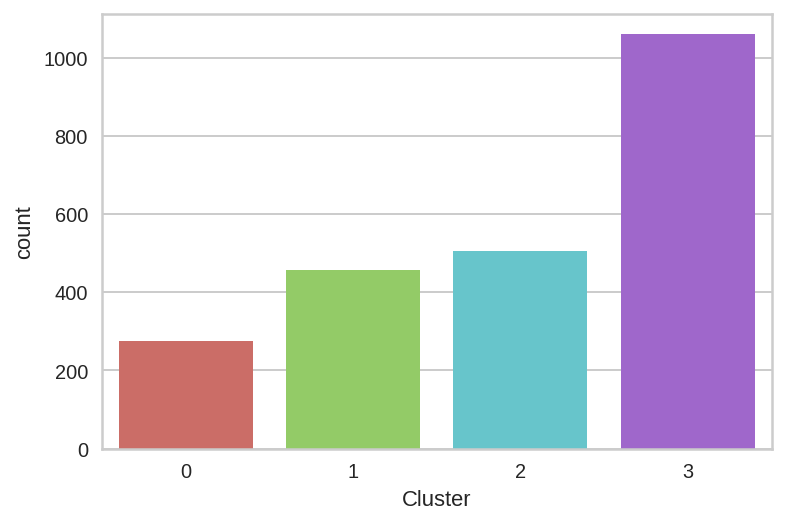

3    1060
2     506
1     458
0     276
Name: Cluster, dtype: int64
cluster_0    1125
cluster_1     782
cluster_3     384
cluster_2       9
Name: Cluster, dtype: int64


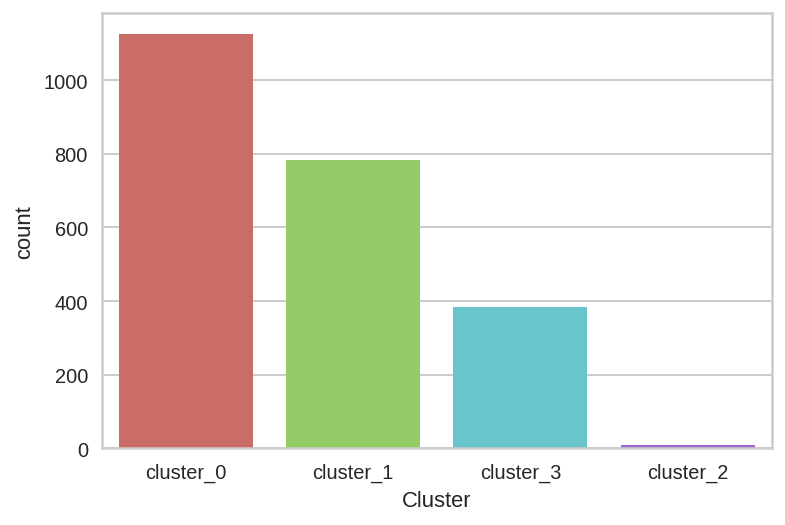

In [ ]:
sns.countplot(data=df_final_bis_clustered,x='Cluster',palette="hls")
plt.show()
sns.countplot(data=knime_bis,x='Cluster',palette='hls')
print(df_final_bis_clustered['Cluster'].value_counts())
print(knime_bis['Cluster'].value_counts())